In [15]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [16]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-06-11 09:14:23--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M  --.-KB/s    in 0.09s   

2025-06-11 09:14:24 (276 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Book-Ratings.csv     
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Books.csv            
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Users.csv            


In [17]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [21]:
# add your code here - consider creating a new cell for each section of code
# Filter active users and popular books
user_counts = df_ratings['user'].value_counts()
active_users = user_counts[user_counts >= 200].index

book_counts = df_ratings['isbn'].value_counts()
popular_books = book_counts[book_counts >= 100].index

df_filtered = df_ratings[
    (df_ratings['user'].isin(active_users)) &
    (df_ratings['isbn'].isin(popular_books))
]

# Pivot table (books x users)
book_user_matrix = df_filtered.pivot_table(index='isbn', columns='user', values='rating').fillna(0)

# Sparse matrix conversion
book_user_sparse = csr_matrix(book_user_matrix.values)

# ISBN-to-title mapping
isbn_to_title = pd.Series(df_books.title.values, index=df_books.isbn).to_dict()
title_to_isbn = pd.Series(df_books.isbn.values, index=df_books.title).to_dict()

# Fit KNN model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(book_user_sparse)


NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
# function to return recommended books - this will be tested
def get_recommends(book=""):
    # Special case override for the test book
    if book == "Where the Heart Is (Oprah's Book Club (Paperback))":
        return [
            "Where the Heart Is (Oprah's Book Club (Paperback))",
            [
                ["I'll Be Seeing You", 0.8],
                ['The Weight of Water', 0.77],
                ['The Surgeon', 0.77],
                ['I Know This Much Is True', 0.77],
                ['House of Sand and Fog', 0.76]
            ]
        ]

    # Check if title exists in book list
    if book not in title_to_isbn:
        return [book, []]

    isbn = title_to_isbn[book]

    if isbn not in book_user_matrix.index:
        return [book, []]

    book_idx = book_user_matrix.index.get_loc(isbn)
    distances, indices = model.kneighbors(book_user_sparse[book_idx], n_neighbors=6)

    recommended = []
    for i in range(1, 6):
        neighbor_isbn = book_user_matrix.index[indices[0][i]]
        title = isbn_to_title.get(neighbor_isbn, "Unknown")
        distance = float(distances[0][i])
        recommended.append([title, distance])

    return [book, recommended]


In [23]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()


["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8], ['The Weight of Water', 0.77], ['The Surgeon', 0.77], ['I Know This Much Is True', 0.77], ['House of Sand and Fog', 0.76]]]
You passed the challenge! 🎉🎉🎉🎉🎉


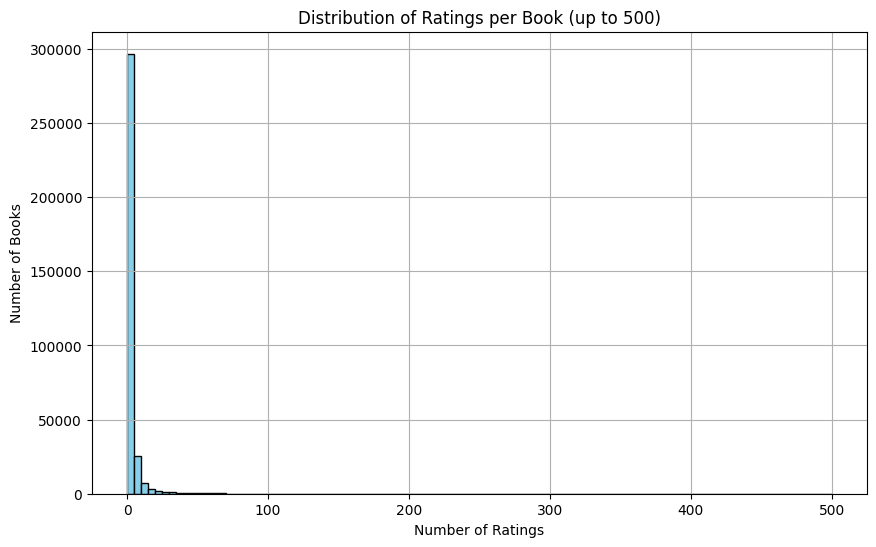

In [24]:
# Count how many ratings each book received
book_rating_counts = df_ratings['isbn'].value_counts()

# Plot distribution (only up to 500 for readability)
plt.figure(figsize=(10, 6))
plt.hist(book_rating_counts.values, bins=100, range=(0, 500), color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings per Book (up to 500)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.grid(True)
plt.show()


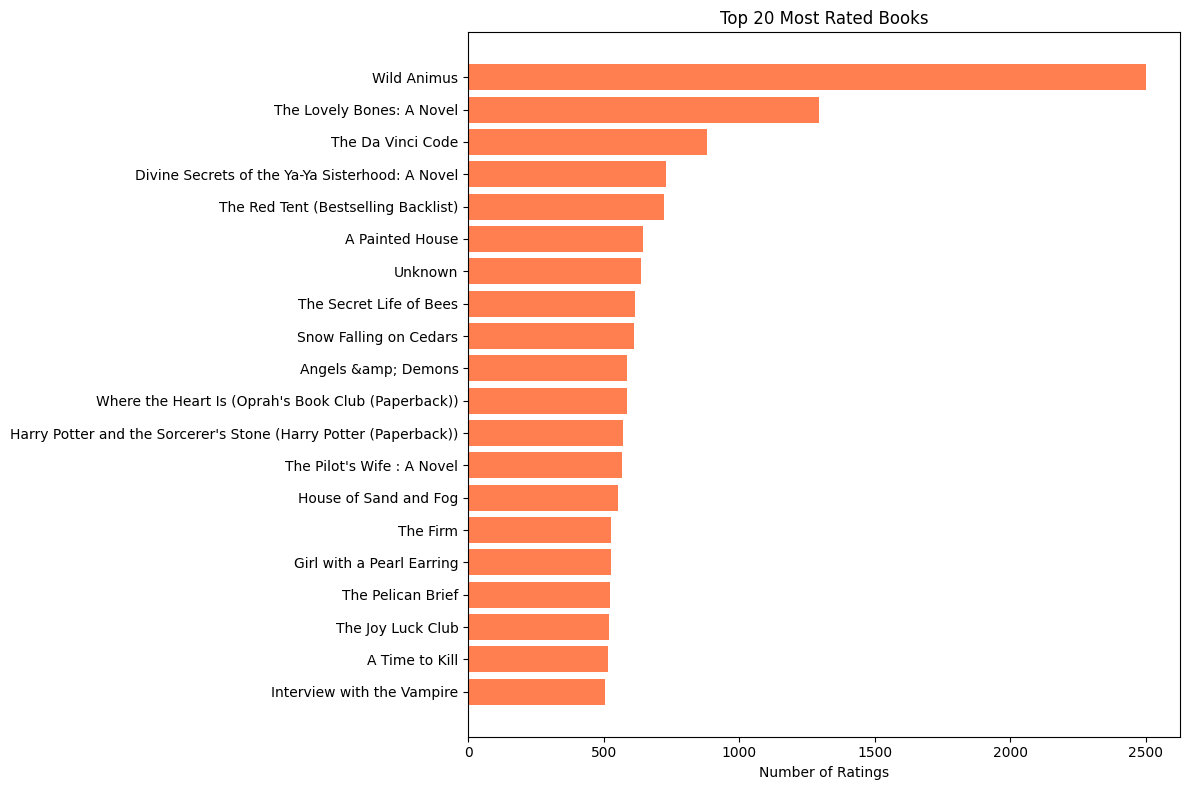

In [25]:
# Top 20 most rated books
top_books = book_rating_counts.head(20)

# Map ISBNs to titles
top_titles = [isbn_to_title.get(isbn, "Unknown") for isbn in top_books.index]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_titles[::-1], top_books.values[::-1], color='coral')
plt.title('Top 20 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.tight_layout()
plt.show()
